<a href="https://colab.research.google.com/github/sophie-bickford/PBIML-Forest-Fires/blob/main/Bickford_Forest_Fires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Introduction to the Forest Fires Dataset

Variables:
- X: x-axis coordinate within the park (int, 1-9)
- Y: y-axis coordinate within the park (int, 2-9)
- month: month of the year (string)
- day: day of the week (string)
- FFMC: Fine Fuel Moisture Code, moisture content in litter and other fine fuels. Indicates how easily fine fuel ignites and burns. (double)
- DMC: Duff Moisture Code, moisture content in duff (coniferous needles, lightly compacted on the ground, see: https://en.wikipedia.org/wiki/Wildfire#Spread) (double).
- DC: Drought Code, avg moisture of deep, organic layers. Useful to understand drought effects on fuel in forest
- ISI: Initial Spread Index, expected rate of fire spread, based on wind and FFMC, but does not take fuel types into account
- temp: temperature in degrees Celsius
- RH: relative humidity, %
- wind: wind speed, km/h
- rain: amount of rain in millimeters/square meter
- area: TARGET VARIABLE, the burned area of the forest sector in hectares (10,000 square meters, 1/100th of a square kilometer)


Additionally, see https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi
https://archive.ics.uci.edu/dataset/162/forest+fires
http://www3.dsi.uminho.pt/pcortez/fires.pdf


more resources:
https://en.wikipedia.org/wiki/Forest_fire_weather_index
https://en.wikipedia.org/wiki/National_Fire_Danger_Rating_System

Persona: Our aim is to calculate the risk of forest fires and predict whether an area, given certain environmental factors, is likely to be heavily affected by fire. Although our dataset only includes data on one park, the results of this project can be applied to other forest locations as we build up a comprehensive understanding of our data variables and their impact on forest fire predictions.

The main challenge of this project is dealing with overfitting. Given that the dimensions of our dataset are 517 rows and 12 columns, the high dimensionality may lead to overfitting.
In addition, several of our variables are skewed, so we would need to find solutions for normalization.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("drive/MyDrive/Bickford - PBIML")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('forestfires.csv')

In [ ]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


####Exploratory Data Analysis

To begin our EDA, we first looked at each individual column in our dataset, checking for missing values and examining its distribution.

In [ ]:
data['area'].describe()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

The area column, which was the original target variable, is mostly made up of zeroes. Note the very high standard deviation and low mean. We will examine this column more in depth later on.

In [ ]:
data['temp'].describe()

count    517.000000
mean      18.889168
std        5.806625
min        2.200000
25%       15.500000
50%       19.300000
75%       22.800000
max       33.300000
Name: temp, dtype: float64

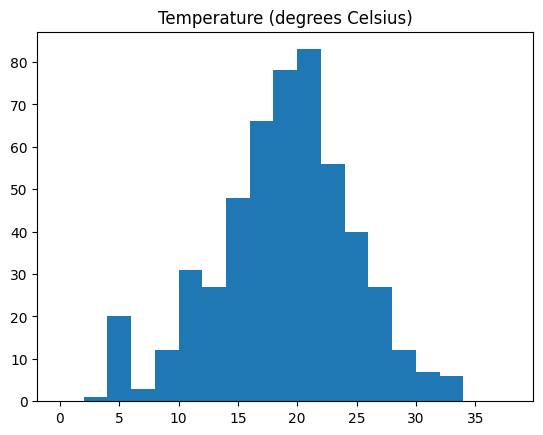

In [ ]:
plt.hist(data['temp'], bins=np.arange(0,40,2))
plt.title('Temperature (degrees Celsius)')
plt.show()

We see a mean temperature of 18 degrees celsius, and the rest seems to be relatively normally distributed, with a spike at around 5 celsius.

In [ ]:
data['RH'].describe()

count    517.000000
mean      44.288201
std       16.317469
min       15.000000
25%       33.000000
50%       42.000000
75%       53.000000
max      100.000000
Name: RH, dtype: float64

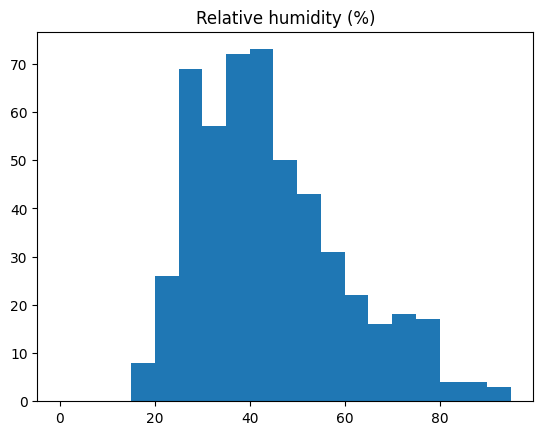

In [ ]:
plt.hist(data['RH'], bins=np.arange(0,100,5))
plt.title('Relative humidity (%)')
plt.show()

Relative humidity is slightly right skewed, with very few values less than 20%.

In [ ]:
data['wind'].describe()

count    517.000000
mean       4.017602
std        1.791653
min        0.400000
25%        2.700000
50%        4.000000
75%        4.900000
max        9.400000
Name: wind, dtype: float64

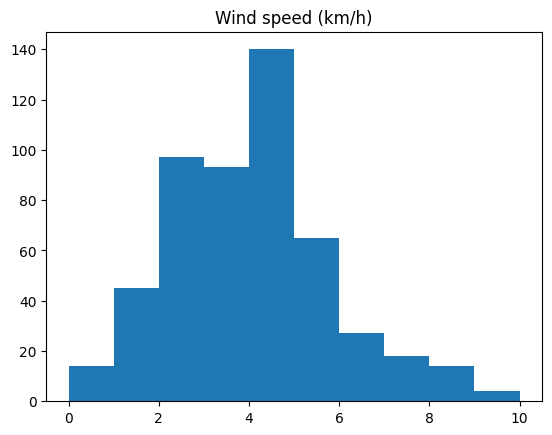

In [ ]:
plt.hist(data['wind'], bins=np.arange(0,11,1))
plt.title('Wind speed (km/h)')
plt.show()

Wind speed is mostly normally distributed.

In [ ]:
data['rain'].describe()

count    517.000000
mean       0.021663
std        0.295959
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.400000
Name: rain, dtype: float64

In [ ]:
data[data['rain'] > 0]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
243,7,4,aug,sun,91.8,175.1,700.7,13.8,21.9,73,7.6,1.0,0.00
286,7,6,jul,wed,91.2,183.1,437.7,12.5,12.6,90,7.6,0.2,0.00
499,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82
500,8,6,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00
501,7,5,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00
502,4,4,aug,tue,96.1,181.1,671.2,14.3,20.7,69,4.9,0.4,0.00
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17


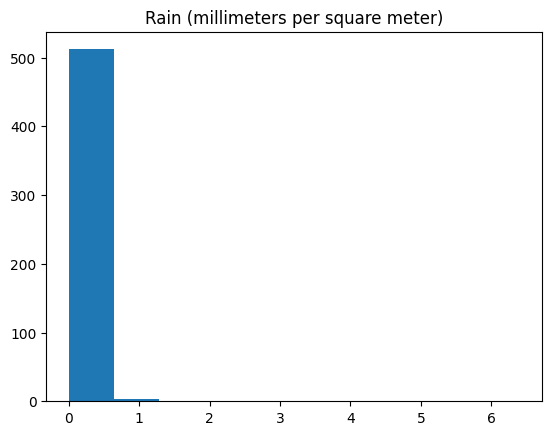

In [ ]:
plt.hist(data['rain'])
plt.title('Rain (millimeters per square meter)')
plt.show()

The rain column only has eight non-zero values. This is likely due to how the data was collected: the variable denotes the accumulated precipiation in the previous 30 minutes before data collection. See the original study for more information here: http://www3.dsi.uminho.pt/pcortez/fires.pdf

In [ ]:
data['area'].describe()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

In [ ]:
data[data['area'] > 0]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
138,9,9,jul,tue,85.8,48.3,313.4,3.9,18.0,42,2.7,0.0,0.36
139,1,4,sep,tue,91.0,129.5,692.6,7.0,21.7,38,2.2,0.0,0.43
140,2,5,sep,mon,90.9,126.5,686.5,7.0,21.9,39,1.8,0.0,0.47
141,1,2,aug,wed,95.5,99.9,513.3,13.2,23.3,31,4.5,0.0,0.55
142,8,6,aug,fri,90.1,108.0,529.8,12.5,21.2,51,8.9,0.0,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17
510,6,5,aug,fri,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.43
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29


(array([493.,  13.,   2.,   4.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600., 650., 700., 750., 800., 850., 900., 950.]),
 <BarContainer object of 19 artists>)

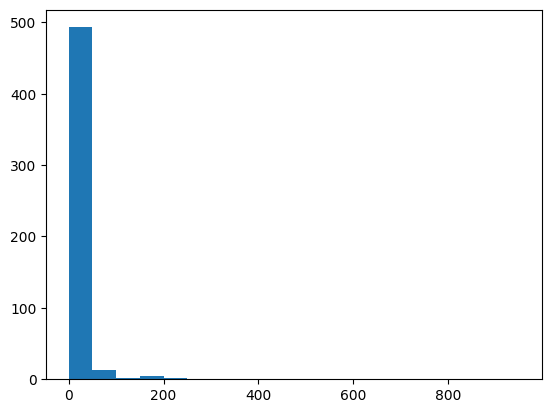

In [ ]:
plt.hist(data['area'], bins=np.arange(0,1000,50))
plt.title('Burned Area (Hectares)')
plt.show()

In [ ]:
data[data['area'] > 100]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
236,2,2,sep,sat,92.5,121.1,674.4,8.6,18.2,46,1.8,0.0,200.94
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


The area column is mostly zeroes, with some small values and a few very large values (more than 100 hectares) and a maximum of almost 1100 hectares.

In [ ]:
data['month'].value_counts()

month
aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: count, dtype: int64

In the month column, a small subset of months make up the vast majority of entries in the dataset. In particular, August and September (which are both summer months) have close to 200 entries each, followed by March with 54 entries.

####Feature Engineering and Selection

In [ ]:
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [ ]:
fire_season = []
fire_season_months = ['jul', 'aug', 'sep']

for index, row in data.iterrows():
  fire_season.append(int(row['month'] in fire_season_months))


data['fire season'] = fire_season


We decided to replace the month column with a binary "fire season" column, displaying whether the observation was taken during fire season in Portugal, which is from July through September. This is done to avoid creating relationships that do not actually exist in the data by label encoding, or overfitting due to one hot encoding, which would result in 12 additional columns.

In [ ]:
data = data.drop(['X', 'Y', 'month','day', 'rain'], axis=1)

In [ ]:
data.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,area
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


We also dropped the X and Y columns because they are locational and could be misleading in our analysis. The month column has been replaced with the fire season column, and the day column is irrelevant because the day of the week should not be correlated with when fires occur. Moreover, we hypothesized that data was likely collected once a week (probably on weekends), and collected more frequently during the week if a fire is present. Therefore, the day column should not be considered in our analysis. The rain column was also excluded because it has only 8 non-zero values (see above).

In [ ]:
is_burned = []

for index, row in data.iterrows():
  is_burned.append(int(row['area'] != 0))

data['area'] = is_burned
data.rename(columns={'area': 'burned'}, inplace=True)

In [ ]:
data['burned'].value_counts()

burned
1    270
0    247
Name: count, dtype: int64

We determined that the area column, which is the target variable, is mostly comprised of zeroes. Because of this, and in addition to our original goal of finding which areas are burned, we decided to make a new categorical target variable, displaying whether or not there is *any* burned area in the forest sector.

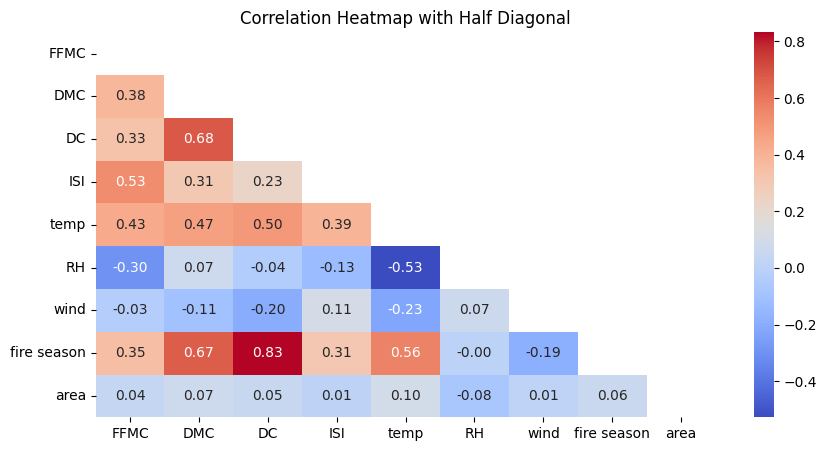

In [ ]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = np.corrcoef(data[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'fire season', 'burned']], rowvar=False)

# Create a mask to hide the upper triangle and the diagonal
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)

# Use Seaborn to plot the heatmap with the mask
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'fire season', 'burned'],
            yticklabels=['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'fire season', 'burned'])
plt.title("Correlation Heatmap with Half Diagonal")
plt.show()

In [ ]:
data['temp'].corr(data['RH']) # this is likely due to how temperature is used to calculate saturation point (used to calculate RH)

-0.5273903386376693

In [ ]:
data['FFMC'].corr(data['ISI'])

0.5318049310435652

In [ ]:
data['DMC'].corr(data['DC'])

0.6821916119833167

In [ ]:
data['fire season'].corr(data['DC'])

0.8320181110584011

Looking at the correlation matrix, we noticed high correlations between the Fire Weather Index (FWI) metrics and the newly engineered fire season column. We determined that the FWI metrics are likely highly correlated with each other because combinations of the same environmental variables (soil/leaf litter dryness, wind speed, etc.) are used to calculate them. These conditions are also likely to happen in certain times of year, hence the correlation with the fire season column.

####Data Normalization and Outlier Removal

In [ ]:
data.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,burned
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0


In [ ]:
data['ISI'].describe()

count    517.000000
mean       9.021663
std        4.559477
min        0.000000
25%        6.500000
50%        8.400000
75%       10.800000
max       56.100000
Name: ISI, dtype: float64

In [ ]:
data = data[data['ISI'] < 30]

(array([ 20.,  40.,  85., 165.,  88.,  38.,  40.,  31.,   6.,   3.]),
 array([ 0.  ,  2.27,  4.54,  6.81,  9.08, 11.35, 13.62, 15.89, 18.16,
        20.43, 22.7 ]),
 <BarContainer object of 10 artists>)

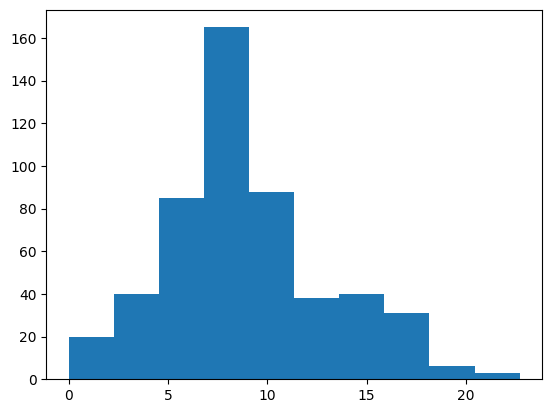

In [ ]:
plt.hist(data['ISI'])

The one extreme outlier in the ISI column has been removed via row deletion. Nothing else about the row in question was anomalous, leaving the outlier completely unexplained, so we decided to remove the row entirely.

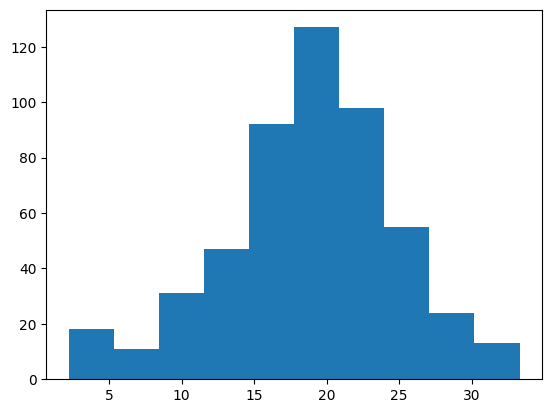

In [ ]:
plt.hist(data['temp'])
plt.title('Temperature (no transformation)')
plt.show()

In [ ]:
from scipy.stats import boxcox

data['temp'], _ = boxcox(data['temp'])

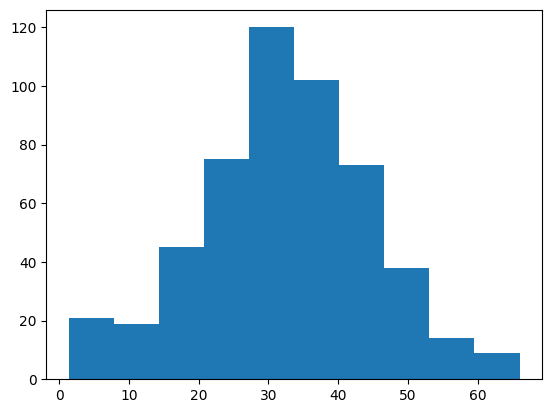

In [ ]:
plt.hist(data['temp'])
plt.title('Temperature (Box-Cox Transformation)')
plt.show()

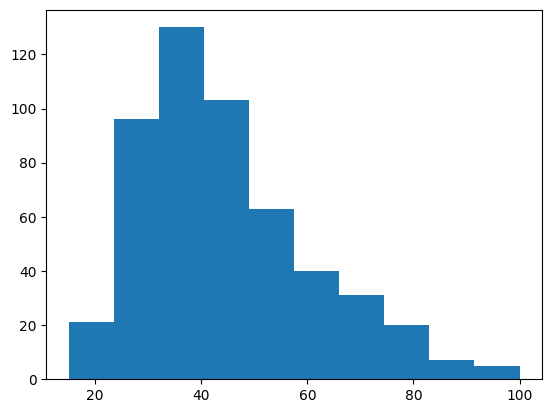

In [ ]:
plt.hist(data['RH'])
plt.title('Relative Humidity (no transformation)')
plt.show()

In [ ]:
from scipy.stats import boxcox

data['RH'], _ = boxcox(data['RH'])

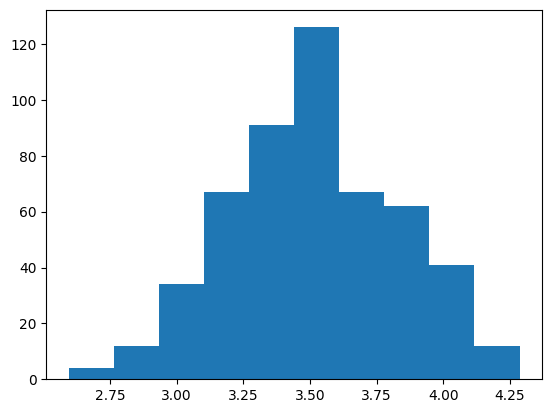

In [ ]:
plt.hist(data['RH'])
plt.title('Relative Humidity (Box-Cox Transformation)')
plt.show()

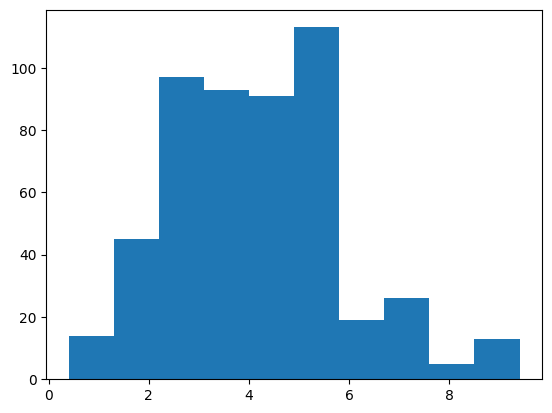

In [ ]:
plt.hist(data['wind'])
plt.title('Wind (no transformation)')
plt.show()

In [ ]:
data['wind'], _ = boxcox(data['wind'])

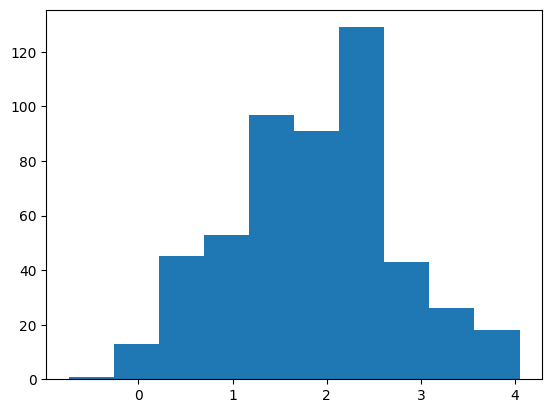

In [ ]:
plt.hist(data['wind'])
plt.title('Wind (Box-Cox Transformation)')
plt.show()

In [ ]:
from scipy.stats import yeojohnson

data['FFMC'], _ = boxcox(data['FFMC'])
data['DMC'], _ = boxcox(data['DMC'])
data['DC'], _ = boxcox(data['DC'])
data['ISI'], _ = yeojohnson(data['ISI'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data['FFMC'] = scaler.fit_transform(data[['FFMC']])
data['DMC'] = scaler.fit_transform(data[['DMC']])
data['DC'] = scaler.fit_transform(data[['DC']])
data['ISI'] = scaler.fit_transform(data[['ISI']])
data['temp'] = scaler.fit_transform(data[['temp']])
data['RH'] = scaler.fit_transform(data[['RH']])
data['wind'] = scaler.fit_transform(data[['wind']])

Through our analysis, we discovered that none of the variables are adequately normally distributed (some more so than others). We decided to utilize Box-Cox and Yeo Johnson transformations to normalize the data, demonstrated in the plots above. We also scaled the data so that every variable will be considered equally by the model.

In [ ]:
data.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,burned
0,0.248407,0.192908,0.039677,0.351356,0.142144,0.651921,0.806892,0
1,0.467200,0.239852,0.694361,0.429670,0.441072,0.422909,0.133123,0
2,0.467200,0.278483,0.721297,0.429670,0.330678,0.422909,0.213021,0
3,0.544509,0.229572,0.029590,0.531138,0.144854,0.984414,0.567348,0
4,0.388919,0.311561,0.044716,0.555938,0.232855,0.994859,0.296627,0


####Random Forests Model and Feature Importance Analysis

In [ ]:
from sklearn.model_selection import train_test_split
input_features = data.drop(columns=['burned'])
target = data['burned']

X_train, X_test, y_train, y_test = train_test_split(input_features, target, test_size=0.2, stratify = target, random_state=42)

In [ ]:
from sklearn.tree import  DecisionTreeClassifier

dtc_classifier =  DecisionTreeClassifier(random_state=42, max_depth=5)
# Train the classifier on the training data
dtc_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dtc_classifier.predict(X_test)

#Test for overfitting
# Make predictions on the train data
y_pred_train = dtc_classifier.predict(X_train)

In [ ]:
# Evaluate the model's performance
from sklearn.metrics import accuracy_score,f1_score

test_f1 = f1_score(y_test, y_pred)
train_f1 = f1_score(y_train, y_pred_train)
print(f"Train f1 score: {train_f1}")
print(f"Test f1 score: {test_f1}")


Train f1 score: 0.6510416666666667
Test f1 score: 0.594059405940594


seems like there's some overfitting due to the decrease in f1 between train and test

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_classifier = RandomForestClassifier(max_depth=6,random_state=34, n_estimators = 500)

In [ ]:
# Train the classifier on the training data
RF_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = RF_classifier.predict(X_test)

#Test for overfitting
# Make predictions on the train data
y_pred_train = RF_classifier.predict(X_train)

In [ ]:
# Evaluate the model's performance
from sklearn.metrics import accuracy_score,f1_score

test_f1 = f1_score(y_test, y_pred)
train_f1 = f1_score(y_train, y_pred_train)
print(f"Train f1 score: {train_f1}")
print(f"Test f1 score: {test_f1}")

Train f1 score: 0.8707482993197277
Test f1 score: 0.6324786324786325


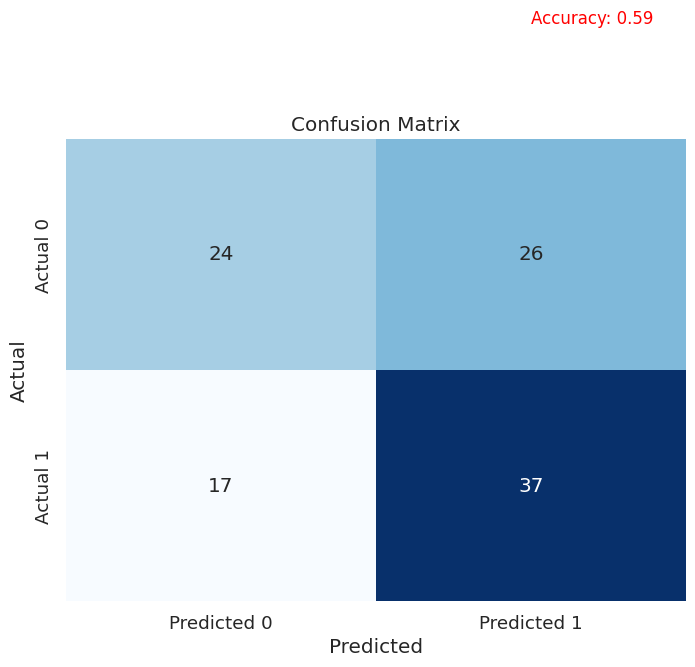

In [ ]:
## Visualize confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Calculate and display the accuracy
accuracy = accuracy_score(y_test, y_pred)
plt.text(1.5, -0.5, f"Accuracy: {accuracy:.2f}", fontsize=12, color="red")

plt.show()

In [ ]:
# Get feature importances
feature_importances = RF_classifier.feature_importances_

# Print the importance of each feature
for feature, importance in zip(input_features.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")

FFMC: 0.1148
DMC: 0.1404
DC: 0.1409
ISI: 0.1178
temp: 0.2064
RH: 0.1616
wind: 0.1182


In [ ]:
def plot_feature_importance(importance, names, model_name):
    #create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # create a dataframe using a dictionary
    data = {'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'],ascending = False, inplace=True)

    #define size of bar plot
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y = fi_df['feature_names'])
    plt.title(model_name + "FEATURE IMPORTANCE")

    #Add chart labels
    plt.xlabel("FEATURE IMPORTANCE")
    plt.ylabel("FEATURE NAMES")

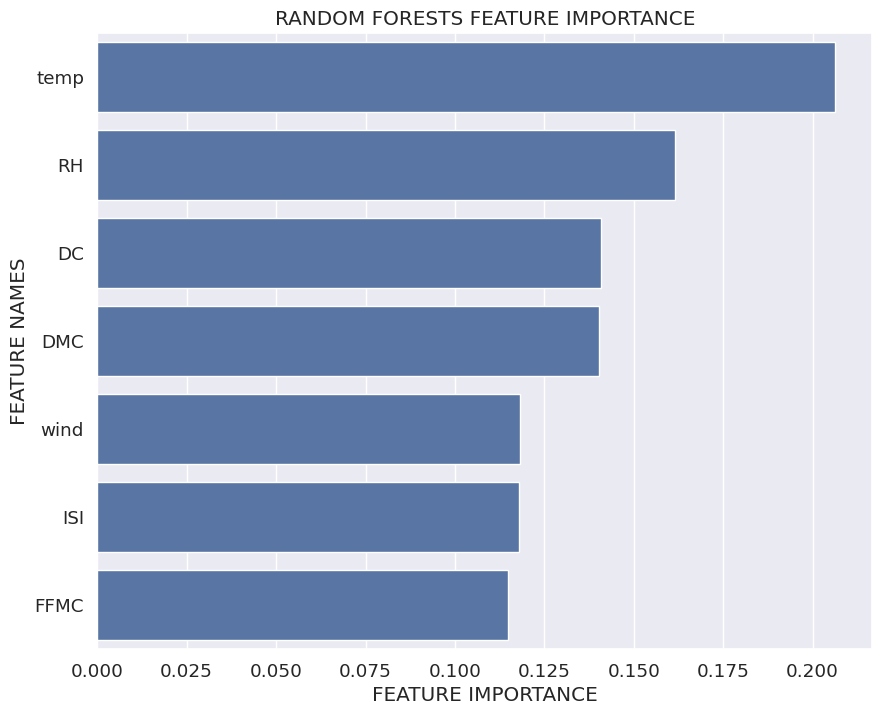

In [ ]:
plot_feature_importance(feature_importances , names = input_features.columns, model_name= "RANDOM FORESTS ")

In [ ]:
data = data.drop(['fire season'], axis=1)

Due to our feature importance evaluation and evidence of some overfitting, we decided to remove the fire season column, since it had almost negligible importance. We only have 617 rows in our dataset, so reducing dimensionality is especially important.